# Cibersortx 下流解析用#  
注意点:  
- それぞれの図が勝手に保存されるので、操作によっては誤って上書きされる可能性があります。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 関数　##  

my_barplot()はシンプルに積み上げ棒グラフを表示する。

In [2]:
def my_barplot(df, fig_name):
    colours = [dct_color_palette[celltype] for celltype in celltypes]
    plt.figure()
    df[celltypes].plot.bar(stacked=True, color=colours)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.savefig(fig_name, bbox_inches="tight")
    plt.show()
    plt.close('all')

my_barplot_sorted()は、細胞種1 (first_item) が一番下に、次に細胞種2 (second_item) が来るようにして積み上げ棒グラフを表示する。

In [3]:
def my_barplot_sorted(df, fig_name,first_item,second_item,show_legends):
    celltype_list_sorted = [item for item in celltypes if item not in [first_item, second_item]]
    celltype_list_sorted = [first_item, second_item] + celltype_list_sorted
    colours = [dct_color_palette[celltype] for celltype in celltype_list_sorted]
    plt.figure()
    df[celltype_list_sorted].plot.bar(stacked=True,color=colours)
    plt.ylabel('Fraction')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    if show_legends==False:
        plt.gca().get_legend().remove()
    plt.savefig(fig_name, bbox_inches="tight")
    plt.show()
    plt.close('all')

my_filter()は単独で呼ばれることもできるが、my_loop()からも呼び出されている。  
バルクに占める細胞種1と細胞種2の割合が、それぞれc1, c2以上であるバルクの数が、head数以上見つかった場合に、my_barplotを呼び出して図示する（戻り値True）。  
見つからなかった場合にはFalseを返す。

In [4]:
### plot first few bulks only
def my_filter(df, first_item, second_item, c1, c2, show_legends, comments=False,head=0,strict=True):
    fig_name = plot_path+'/barplot_filtered_sorted_by_'+first_item+'_'+second_item+'_'+str(c1*100)+'_'+str(c2*100)+'.png'
    comment = 'Sorted by '+first_item+' cell fractions (>='+str(c1*100)+'%), then by '+second_item+' cell fractions (>='+str(c2*100)+'%)'
    df = df[df[first_item] >= c1]
    df = df[df[second_item] >= c2]
    if df.empty == True: #If no bulk met criteria
        if comments == True:
            print(comment+'\n\tNull!')
    else:
        if head:#plot first 'head' number of bulks only
            df=df.loc[df.index[:head]]
            if df.shape[0]>= head:#number of bulks that fit criteria > number of bulks expected in  plot
                print(comment)
                my_barplot_sorted(df.sort_values(by =[first_item,second_item] , ascending=False), fig_name, first_item, second_item, show_legends)
                return True
            if not strict:#head数以下のbulkしかなくても、図示したいときはstrict=False。無視していいoption引数。
                print(comment)
                my_barplot_sorted(df.sort_values(by =[first_item,second_item] , ascending=False), fig_name, first_item, second_item, show_legends)
        else: #headが指定されていなくて、条件にあてはまるバルクは全表示したいとき。
            my_barplot_sorted(df.sort_values(by =[first_item,second_item] , ascending=False), fig_name, first_item, second_item, show_legends)
            return True
    #head数以上のバルクがなかったときと、head指定していないのに一個もバルクが当てはまらなかったときは、False. ループに戻る。
    return False

my_loop()では、  
(cutoff1, cutoff2), (cutoff1 - diff*1, cutoff2), (cutoff1 - diff*2),...,  
(cutoff1, cutoff2 - diff*1), (cutoff1 - diff*1, cutoff2 - diff*1), (cutoff1 - diff*2, cutoff2 - diff*1),...,  
...  
の順でバルクに占めていてほしい細胞種1と細胞種2の割合（cutoff値）が調整されていく。  
条件を満たすバルクが、head数以上見つかった時点で終了。  

In [5]:
#For automatically adjusting parameters when using my_filter() to plot barplots 
def my_loop(df_fractions, first_item, second_item, cutoff1, cutoff2, diff, head, comments=True,strict=True,show_legends=False):
    c1 = cutoff1
    c2 = cutoff2
    while c1 > 0 and c2 > 0:
        if my_filter(df_fractions, first_item, second_item, c1, c2,head=head,comments=comments, strict=strict, show_legends=show_legends):#true == sufficient number of bulks found
            return True
        c1 -= diff
    #ここまで来たときは、returnできなかったときなので、条件を満たすバルク数が足りなかった。
    #2細胞種の割合の差分がdiffだとだめだったので、2*diff, 3*diff,... と広げてみる。(掛ける数はt; t*diff)
    if cutoff1 - diff <0 or cutoff2 - diff<0:
        #これ以上cut off値の上限（ループの開始値）を下げてループできないとき。あきらめる。
        return False
    return my_loop(df_fractions, first_item, second_item, cutoff1, cutoff2-diff, diff,head=head,comments=comments, show_legends=show_legends)

## 本体　##

#### データ読み込みと、概観確認 ####
Cibersortxの出力ファイル（このノートブックの入力ファイル）を変えるとき（肝臓→腎臓など）は、次のセルを編集する。

In [6]:
filename_fractions = 'CIBERSORTx_Job56_results.txt'

In [7]:
# import data
df_fractions = pd.read_csv(filename_fractions,sep='\t',index_col=0)

In [8]:
#図を保存したい先のフォルダ
plot_path = './plots'

データの概観を見てみる。

In [9]:
df_fractions.head()

,B,Hepato,Kuppfer,T,Epi,DC,Macro,Endo,Gran,Eryth,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,,,
AAAAAAAAAAAA,0.059047,0.104776,0.000000,0.000000,0.082413,0.611312,0.000000,0.103970,0.038483,0.000000,0,0.006743,1.046291
AAAAAATTGGTA,0.105854,0.288115,0.032688,0.000000,0.105428,0.267073,0.000000,0.200843,0.000000,0.000000,0,0.290071,0.967373
AAAAAATTGGTC,0.000000,0.151857,0.000000,0.278388,0.133523,0.035342,0.000000,0.125441,0.000000,0.275449,0,0.269819,0.964097
AAAAAATTGGTG,0.000000,0.433792,0.194482,0.000000,0.037845,0.130131,0.000000,0.000000,0.000000,0.203750,0,0.456191,0.892178
AAAAAATTGGTT,0.000000,0.336852,0.097438,0.148101,0.098314,0.234700,0.046934,0.037660,0.000000,0.000000,0,0.399391,0.917445


In [10]:
df_fractions.shape

(19125, 13)

In [11]:
celltypes = [item for item in df_fractions.columns.values if item not in ['P-value', 'Correlation', 'RMSE']]
print('The cell types in this dataset:',celltypes)
print('Total of ',str(len(celltypes)),' cell types')

The cell types in this dataset: ['B', 'Hepato', 'Kuppfer', 'T', 'Epi', 'DC', 'Macro', 'Endo', 'Gran', 'Eryth']
Total of  10  cell types


積み上げ棒グラフの、各細胞種の色を辞書型に保管しておく。  
カスタムの色リストを作ることも可能。  
下記ではseabornの組み込みカラーパレットを利用（e.g. deep, colorblind, Set2）

In [12]:
dct_color_palette = {}
for i in range(len(celltypes)):
    dct_color_palette[celltypes[i]] = sns.color_palette("muted", len(celltypes))[i]

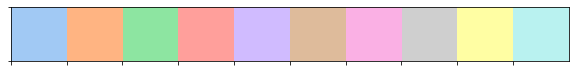

In [13]:
sns.palplot(sns.color_palette("pastel", 10))

## 可視化 ##

とりあえず、プロットしてみる。

<Figure size 432x288 with 0 Axes>

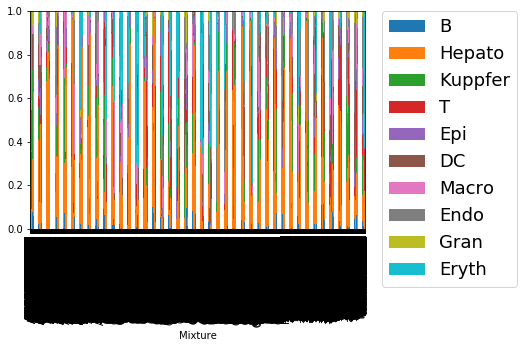

In [17]:
my_barplot(df_fractions,plot_path+'/barplot_all_fractions.png')

#### ソート ####
ある値に着目してソートする。 
**次の次のセルに入力**する。（ちなみに指定可能なラベルは下に表示される通り）    
例：RMSE (説明できなかった誤差) でソートした上で、プロット。

In [55]:
print(df_fractions.columns.values)

['B' 'Hepato' 'Kuppfer' 'T' 'Epi' 'DC' 'Macro' 'Endo' 'Gran' 'Eryth'
 'P-value' 'Correlation' 'RMSE']


In [12]:
##ここに入力
val = 'RMSE'

Sorted by RMSE


<Figure size 432x288 with 0 Axes>

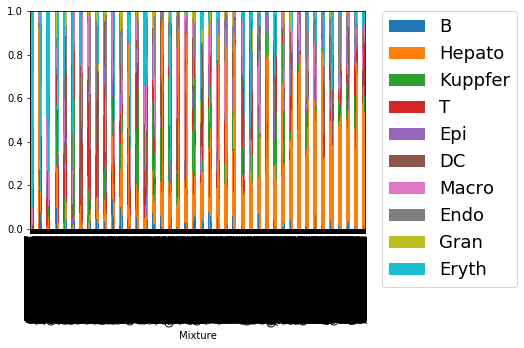

In [13]:
print('Sorted by '+val)
my_barplot(df_fractions.sort_values(by =[val] , ascending=False), plot_path+'/barplot_sorted_by_'+val+'.png')

細胞種Aの割合が多い順にバルクをソートして、次に細胞種Bの割合が多い順にソートする。

Sorted by B cell fractions, then by Hepato cell fractions


<Figure size 432x288 with 0 Axes>

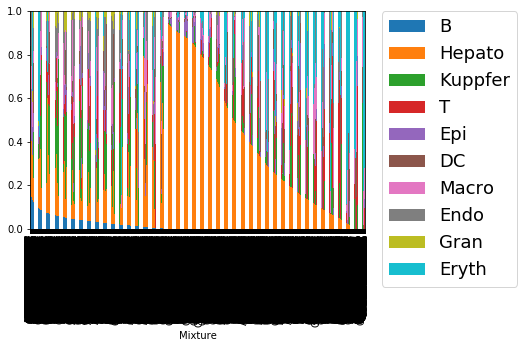

In [14]:
#breakをコメントアウトして使う
for first_item in celltypes:
    #全細胞種の組み合わせを走査する。
    for second_item in celltypes:
        if first_item == second_item:
            continue
        print('Sorted by '+first_item+' cell fractions, then by '+second_item+' cell fractions')
        my_barplot(df_fractions.sort_values(by =[first_item,second_item] , ascending=False), plot_path+'/barplot_sorted_by_'+first_item+'_'+second_item+'.png')
        break
    break

#### フィルターをかけたソート ####
2種の細胞種が「ある程度の割合」ずつ（下記のデフォルトでは40%ずつ）いるようなバルクを図示したい。

～やっていること～  
cutoff1 = 0.4, cutoff2 = 0.35だったとき、細胞種1が40％以上、細胞種2が35％以上あるバルクを探す。  
→cutoff値の設定や細胞種の組み合わせを【手動】でやるときは、my_filter()を使う（【手動版】）  

- 条件にあてはまるバルクが多い時は、headに任意の値を設定することでその数分だけ表示できる。デフォルトはhead=0なので全表示。
- strict=True（デフォルト）だと、headに設定した数分だけ、条件にあてはまるバルク数がなかった場合に図は出力されない。
- comments=Trueにすると、条件にあてはまるバルクがなかった時に、その旨が出力される。
  
【自動版】
my_loop()を使って、条件にあてはまるバルクがなかったときに、cutoff1, cutoff2をそれぞれdiff分だけ小さくしていく。


In [14]:
#ここで'ある程度の割合い'を指定

#cut off value for first cell type
cutoff1 = 0.2 
#cut off value for second cell type
cutoff2 = 0.2

#もし、与えた基準に合うバルクが一個もなかった時に、その旨を出力してほしければ、下記をTrueにする。
comments = False

#最初の何バルクを図示したいかを指定
head=20

#ループ内でdiffずつcut off値を変化させていく。
diff = 0.05

#凡例が必要ならTrueにする. my_loop()ではoption引数（デフォルトはFalse）。 my_filter()では指定が必要。
show_legends = False

Sorted by B cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

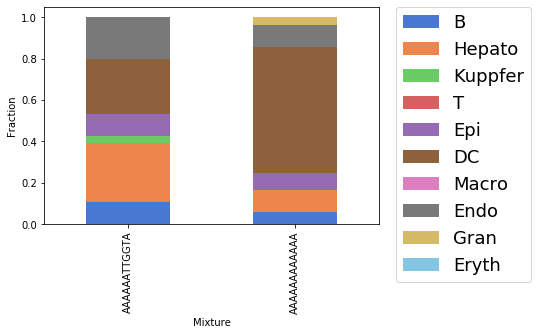

True

In [15]:
#【手動版】
first_celltype = 'B'
second_celltype = 'Hepato'
cutoff1 = 0.01
cutoff2 = 0.01
show_legends = True

my_filter(df_fractions, first_celltype, second_celltype, cutoff1, cutoff2, show_legends, comments=True,head=2)

Sorted by B cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

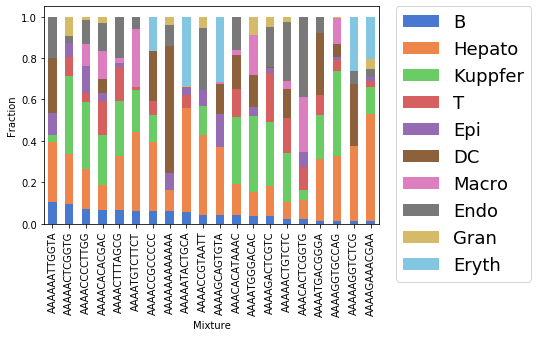

Sorted by B cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

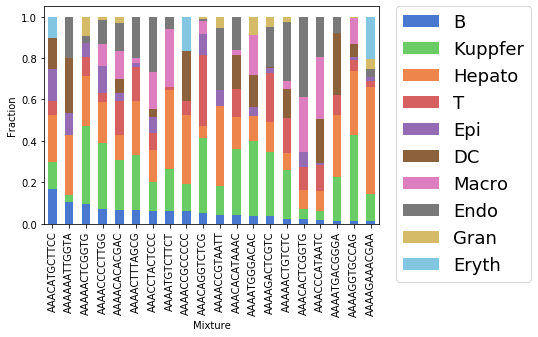

Sorted by B cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

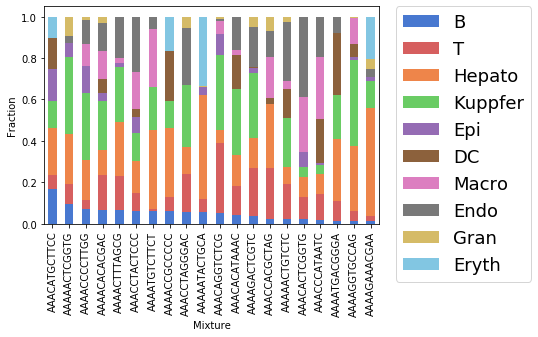

Sorted by B cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

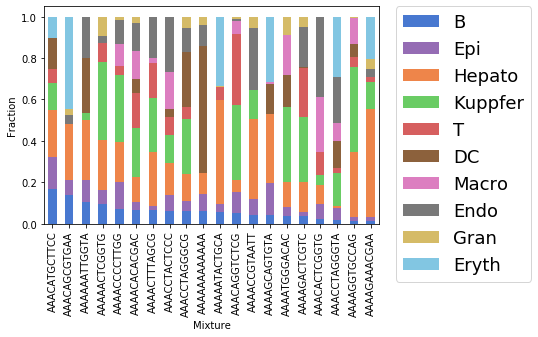

Sorted by B cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

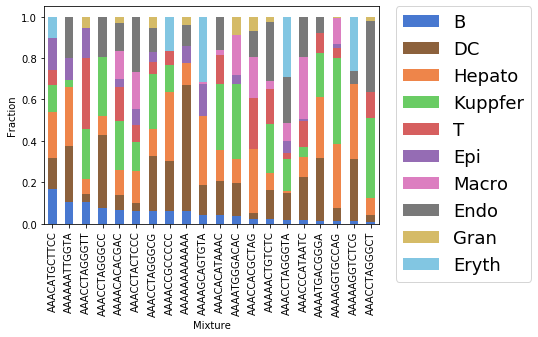

Sorted by B cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

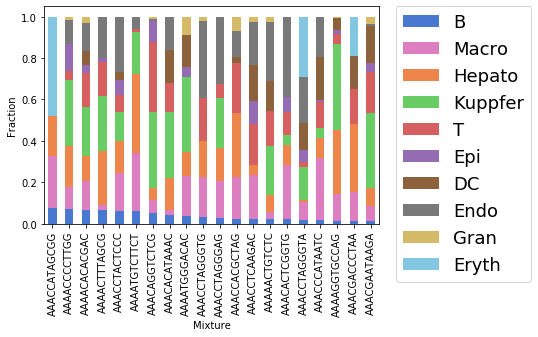

Sorted by B cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

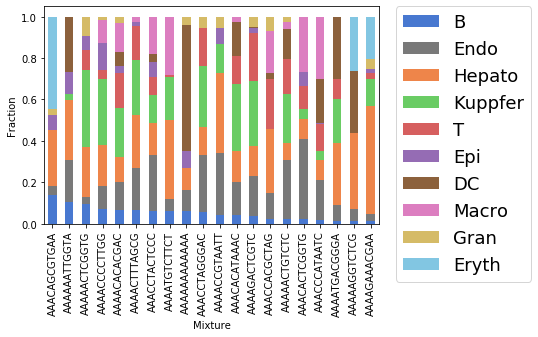

Sorted by B cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

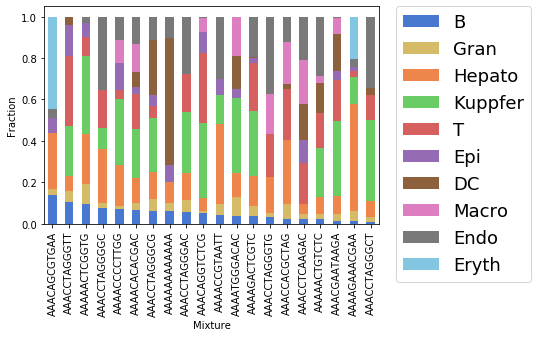

Sorted by B cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

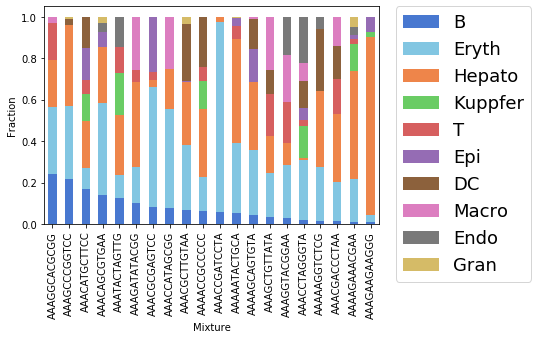

Sorted by Hepato cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

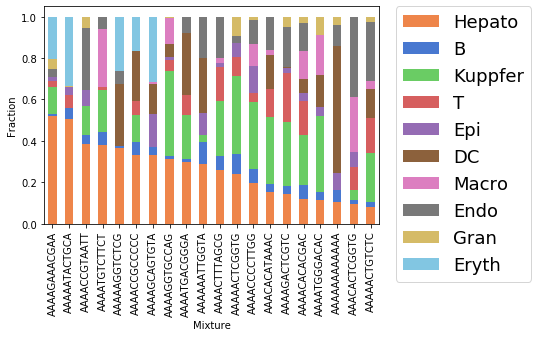

Sorted by Hepato cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

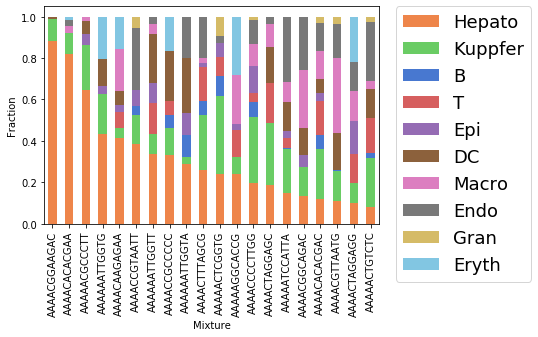

Sorted by Hepato cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

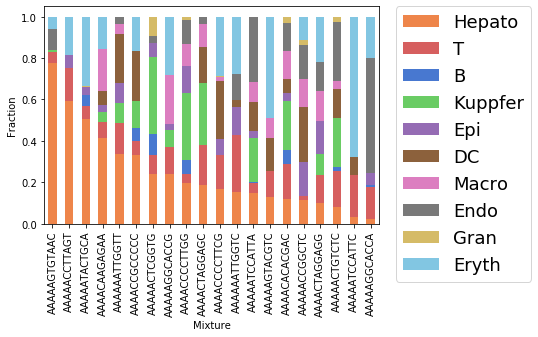

Sorted by Hepato cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

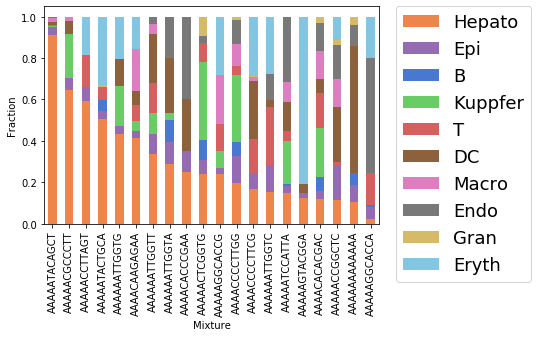

Sorted by Hepato cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

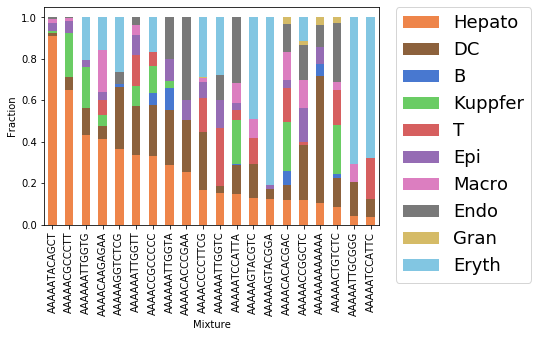

Sorted by Hepato cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

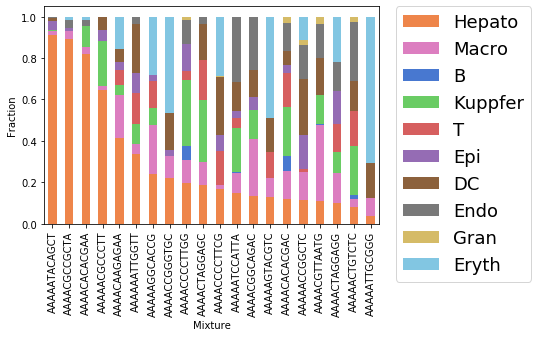

Sorted by Hepato cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

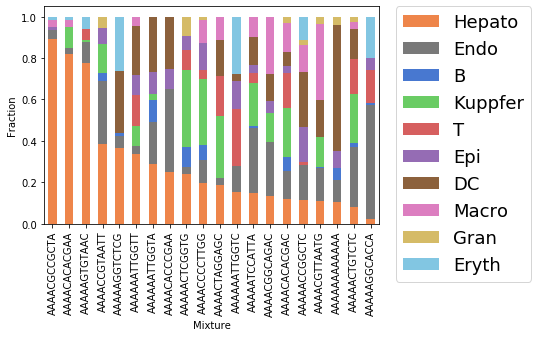

Sorted by Hepato cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

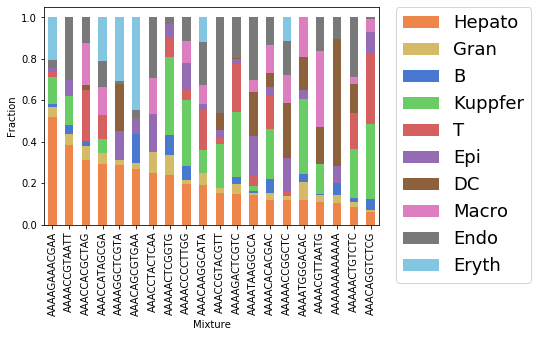

Sorted by Hepato cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

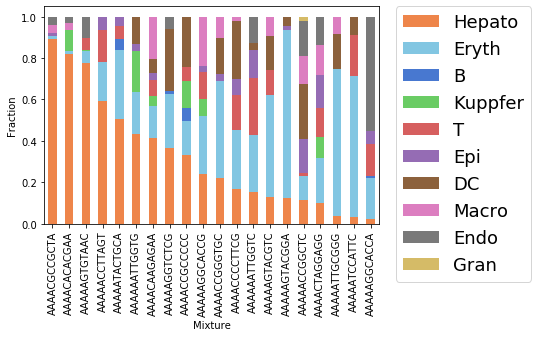

Sorted by Kuppfer cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

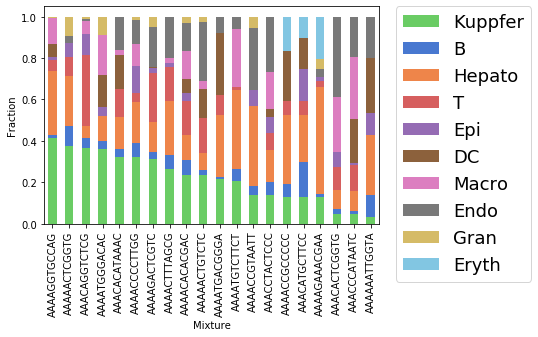

Sorted by Kuppfer cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

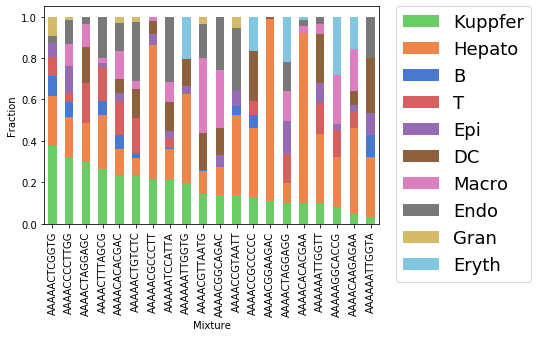

Sorted by Kuppfer cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

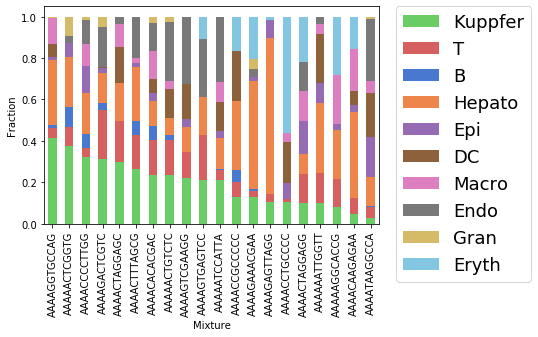

Sorted by Kuppfer cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

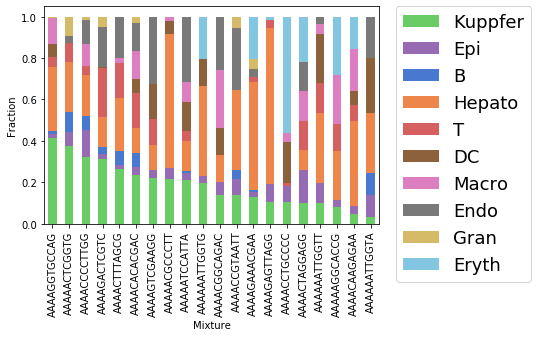

Sorted by Kuppfer cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

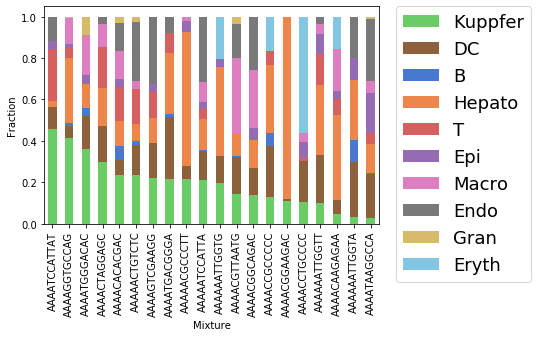

Sorted by Kuppfer cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

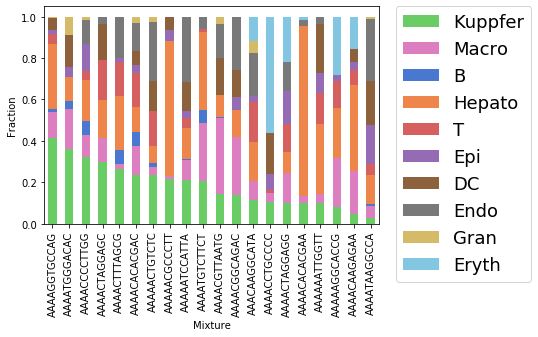

Sorted by Kuppfer cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

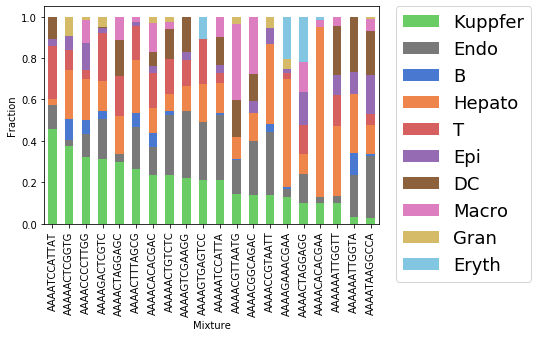

Sorted by Kuppfer cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

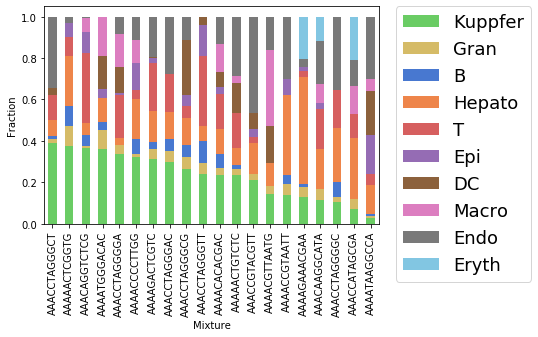

Sorted by Kuppfer cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

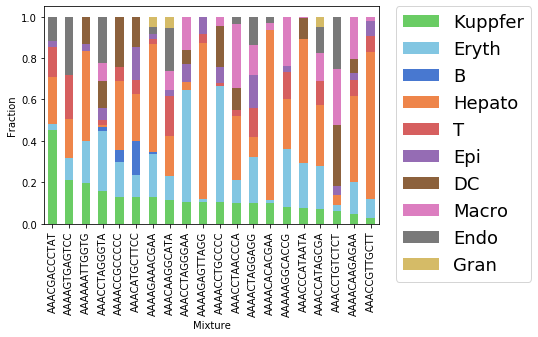

Sorted by T cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

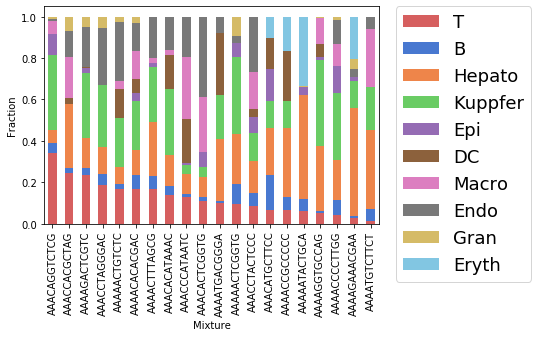

Sorted by T cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

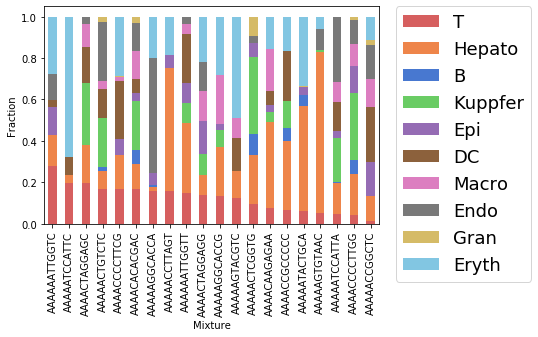

Sorted by T cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

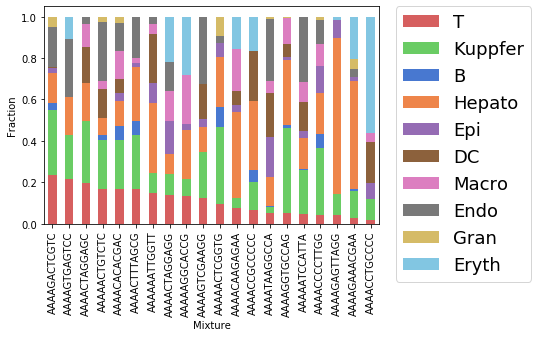

Sorted by T cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

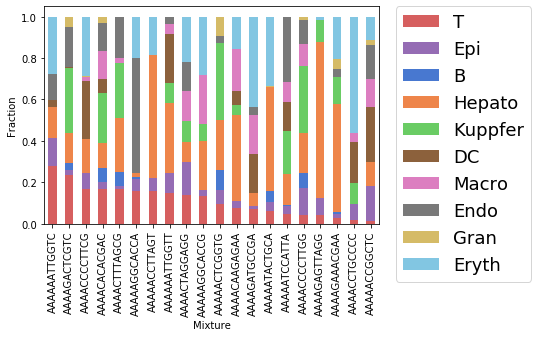

Sorted by T cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

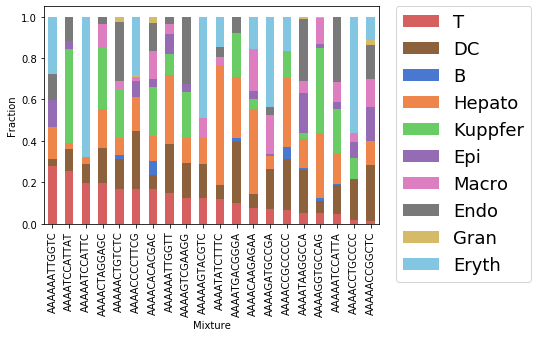

Sorted by T cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

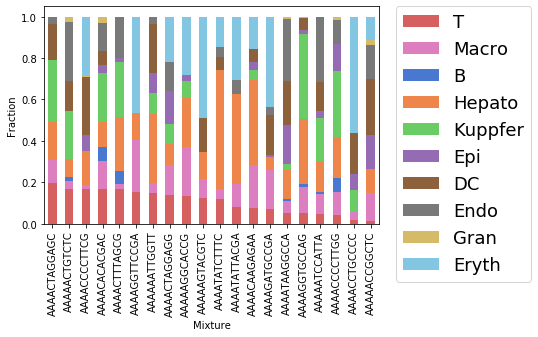

Sorted by T cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

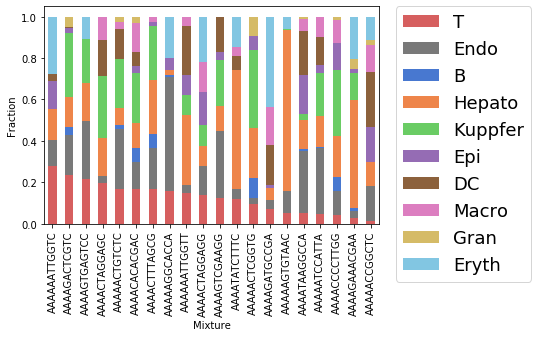

Sorted by T cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

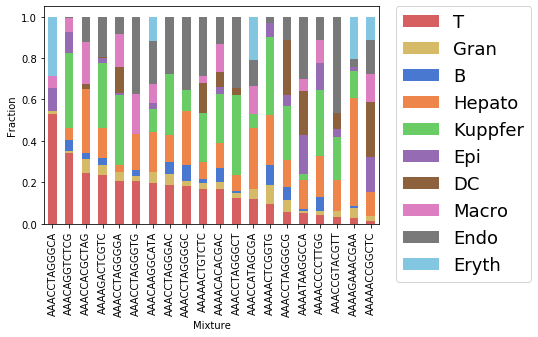

Sorted by T cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

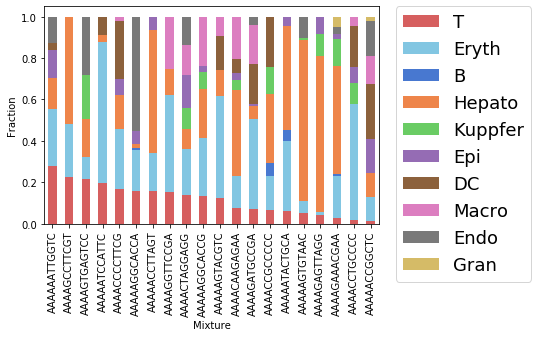

Sorted by Epi cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

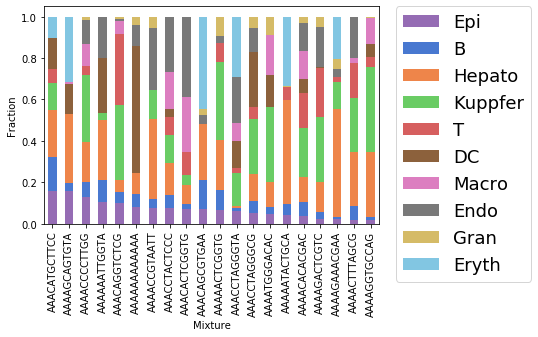

Sorted by Epi cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

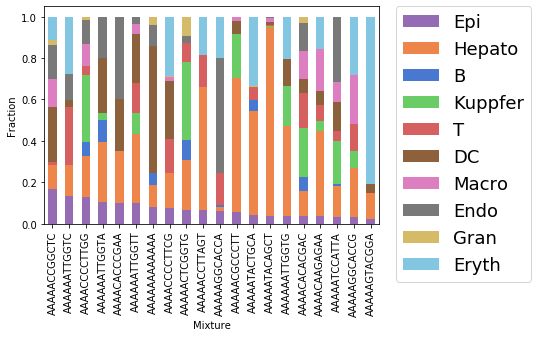

Sorted by Epi cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

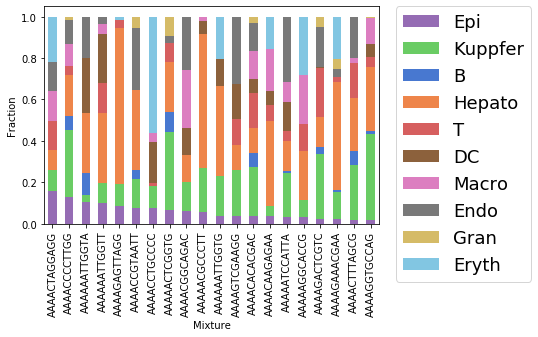

Sorted by Epi cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

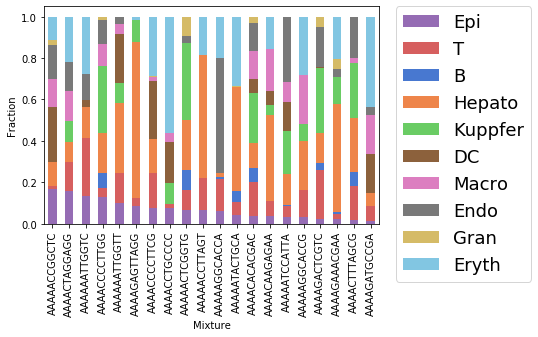

Sorted by Epi cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

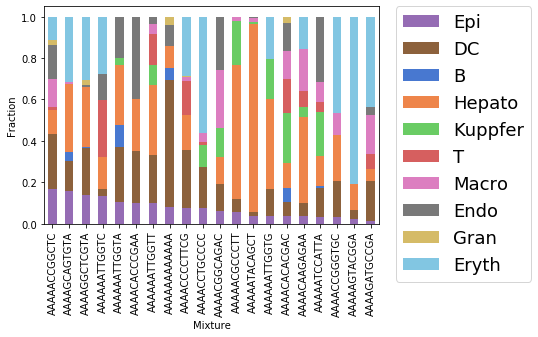

Sorted by Epi cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

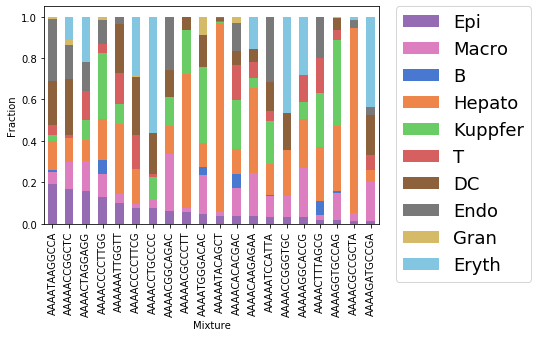

Sorted by Epi cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

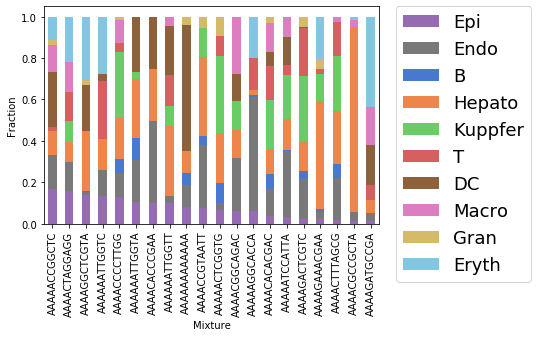

Sorted by Epi cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

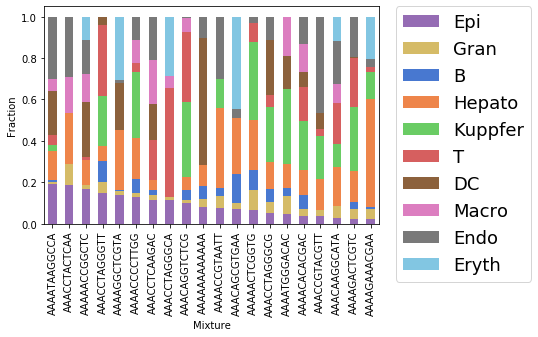

Sorted by Epi cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

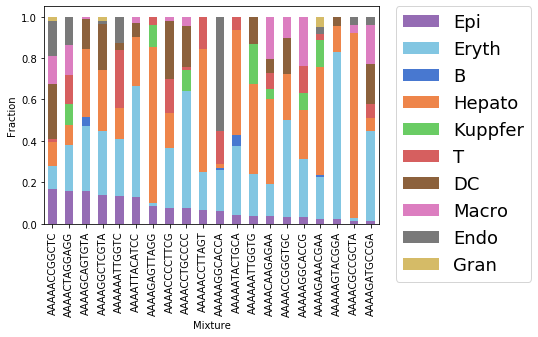

Sorted by DC cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

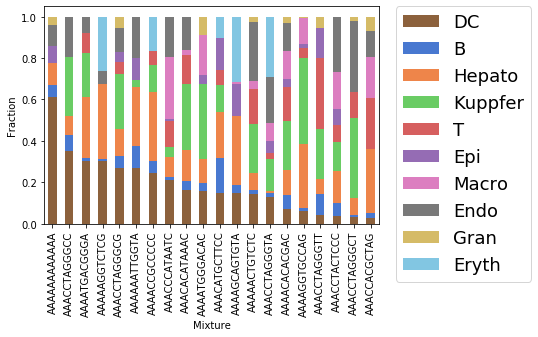

Sorted by DC cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

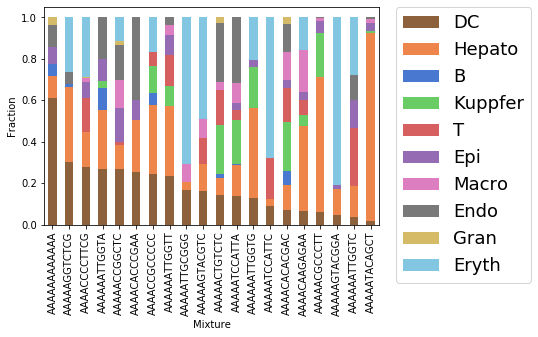

Sorted by DC cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

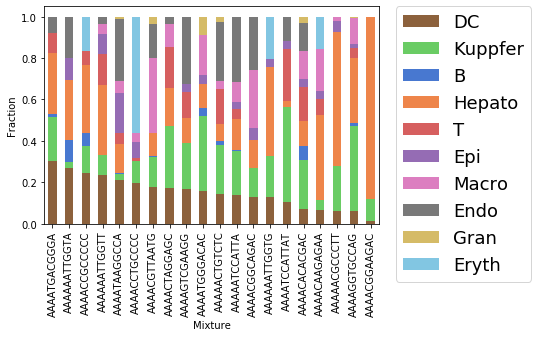

Sorted by DC cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

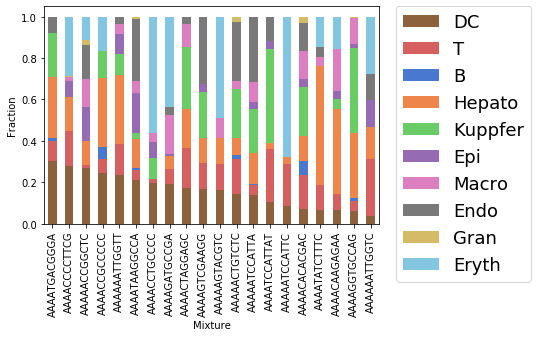

Sorted by DC cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

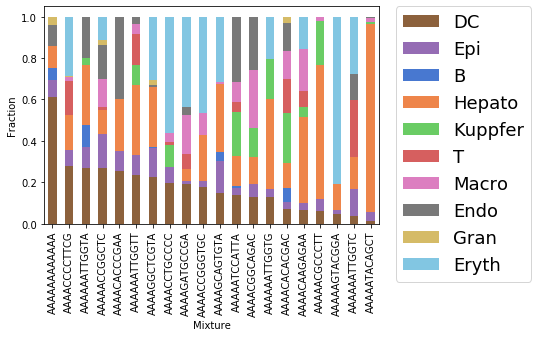

Sorted by DC cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

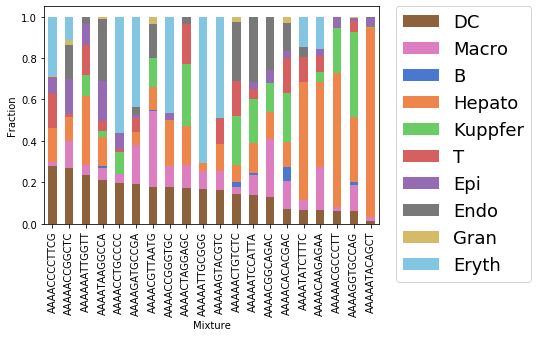

Sorted by DC cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

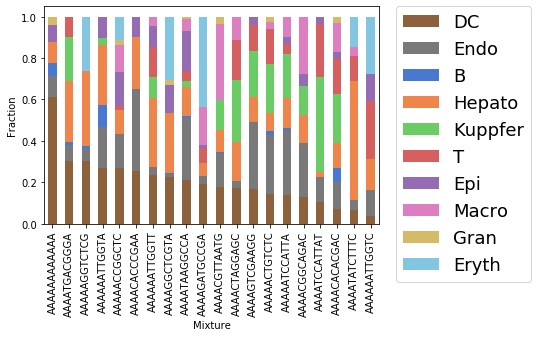

Sorted by DC cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

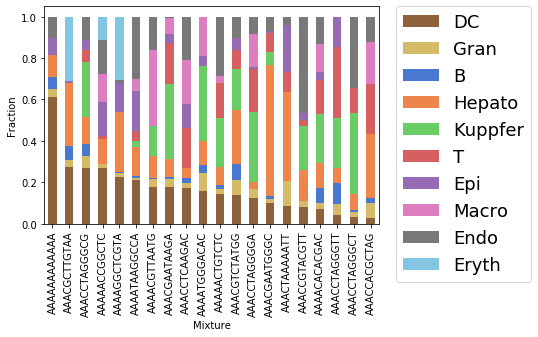

Sorted by DC cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

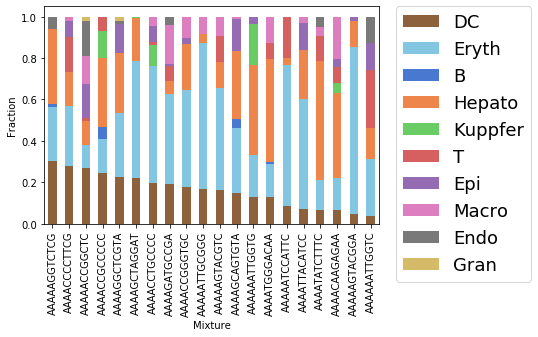

Sorted by Macro cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

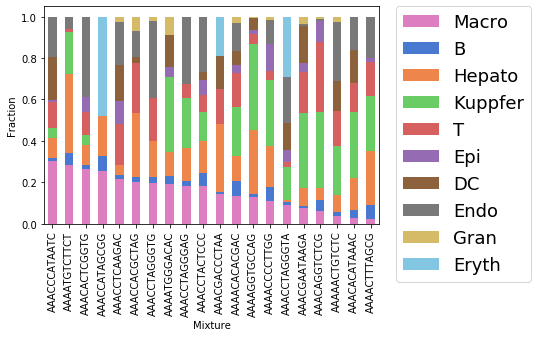

Sorted by Macro cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

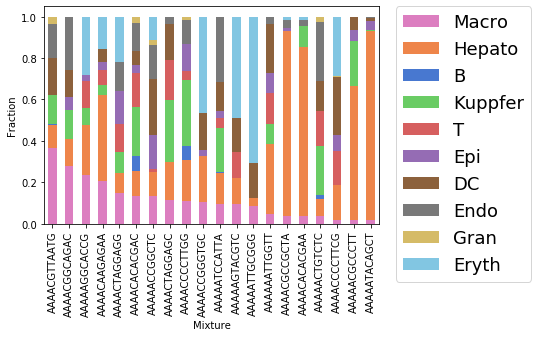

Sorted by Macro cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

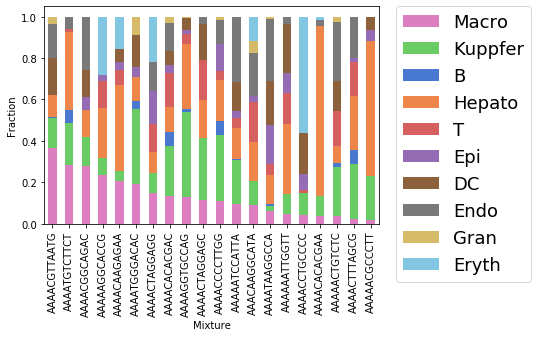

Sorted by Macro cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

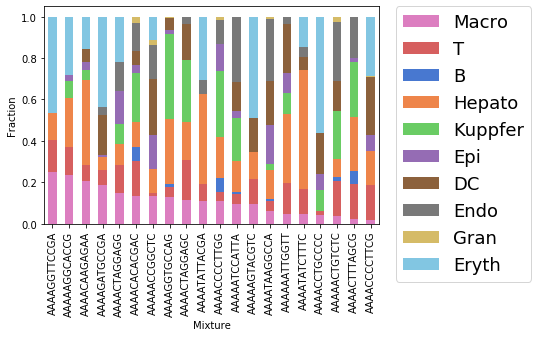

Sorted by Macro cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

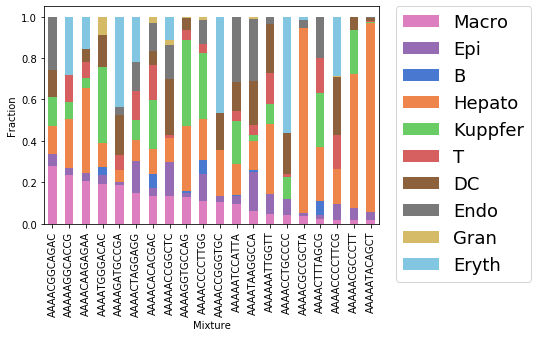

Sorted by Macro cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

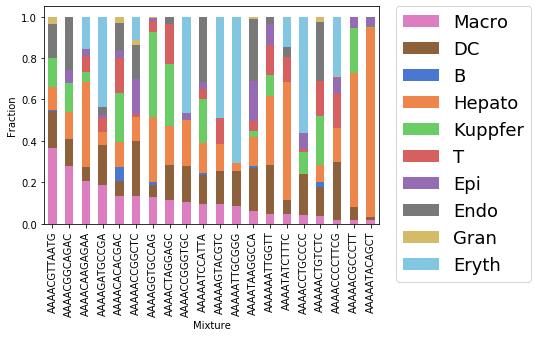

Sorted by Macro cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

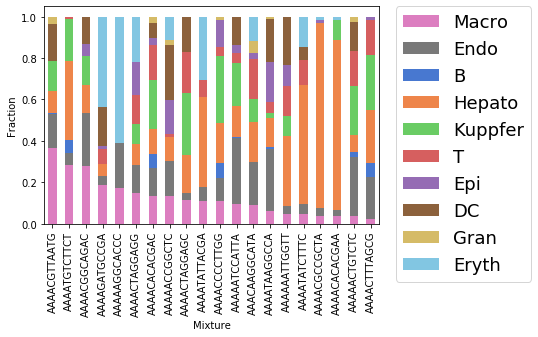

Sorted by Macro cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

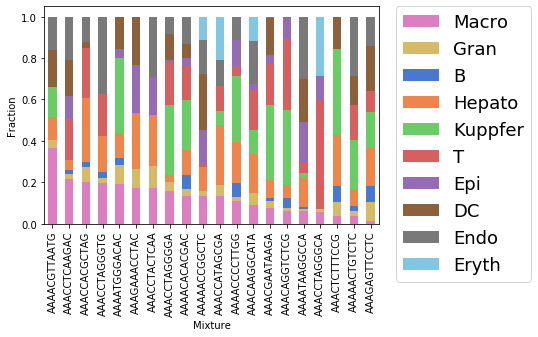

Sorted by Macro cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

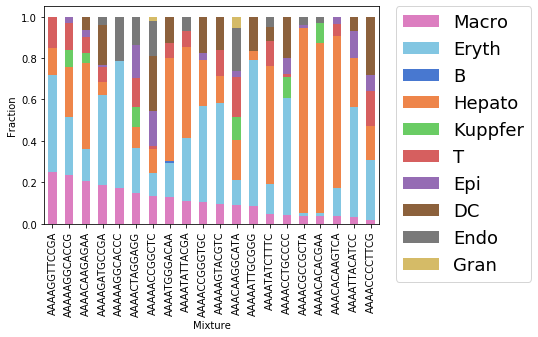

Sorted by Endo cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

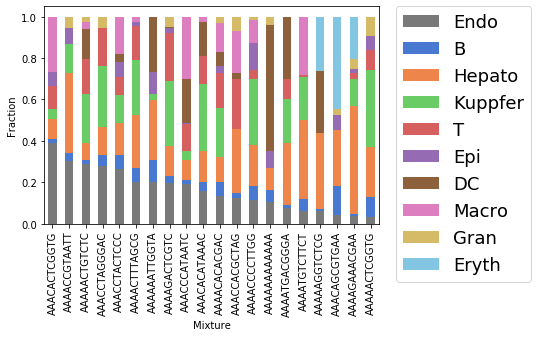

Sorted by Endo cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

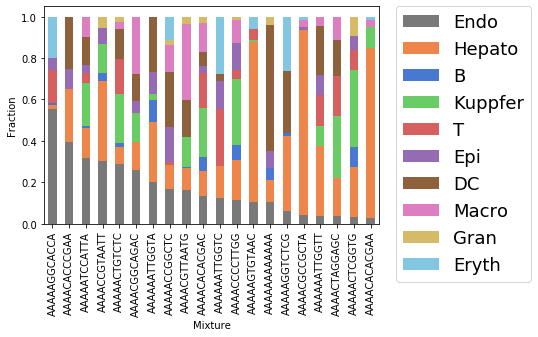

Sorted by Endo cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

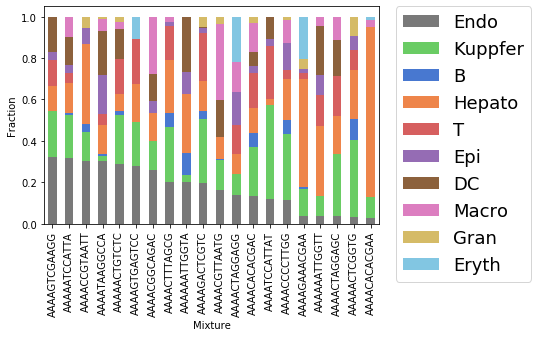

Sorted by Endo cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

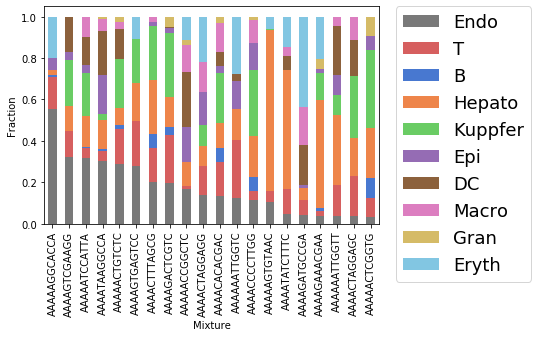

Sorted by Endo cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

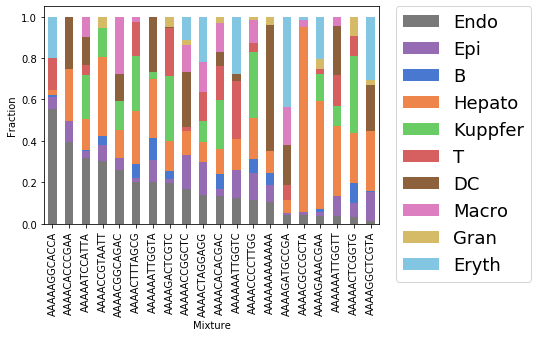

Sorted by Endo cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

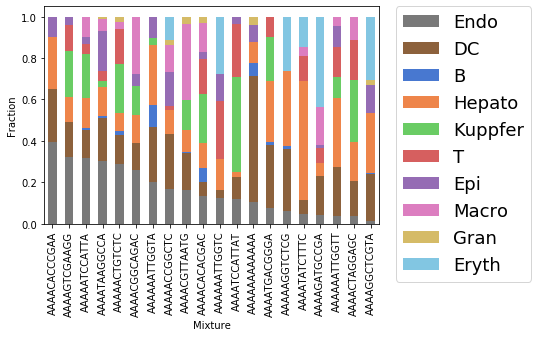

Sorted by Endo cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

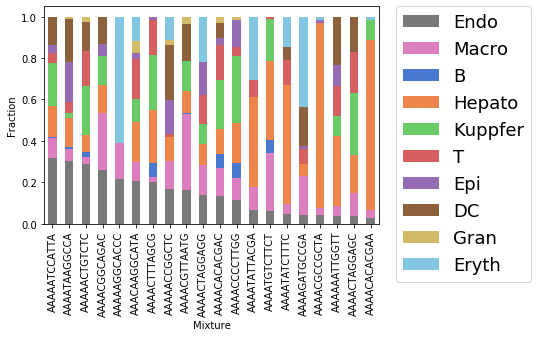

Sorted by Endo cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

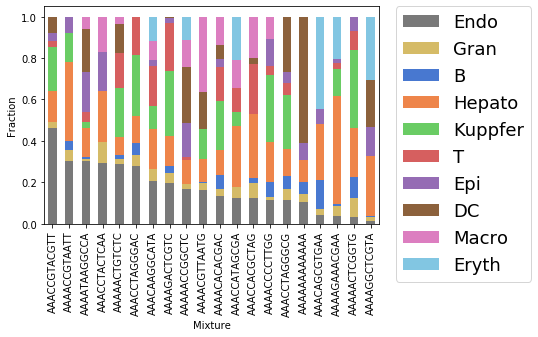

Sorted by Endo cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

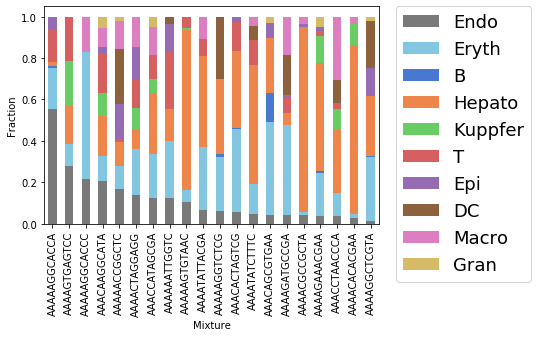

Sorted by Gran cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

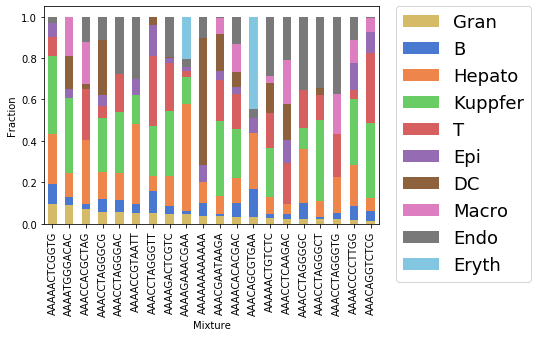

Sorted by Gran cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

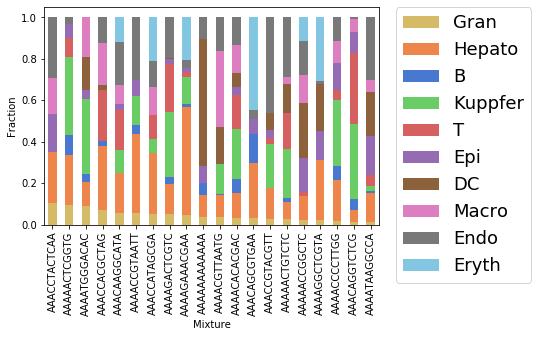

Sorted by Gran cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

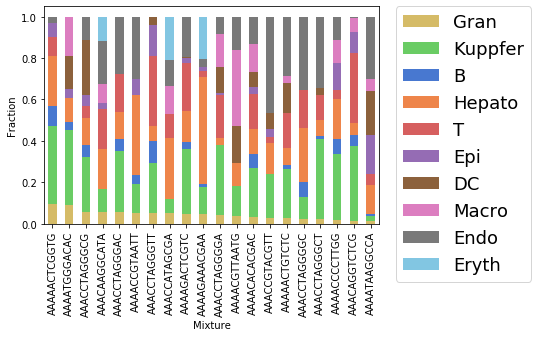

Sorted by Gran cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

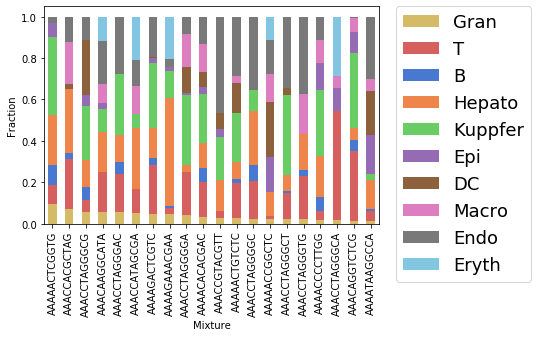

Sorted by Gran cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

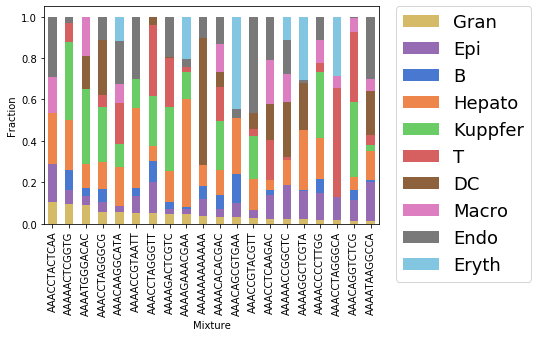

Sorted by Gran cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

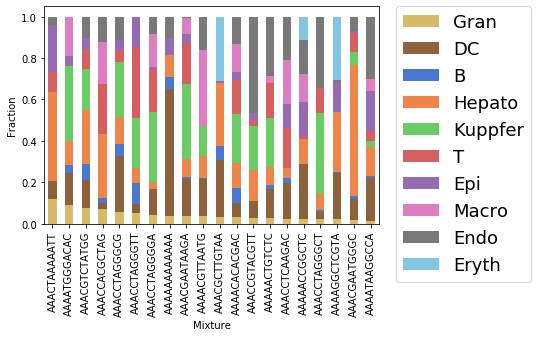

Sorted by Gran cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

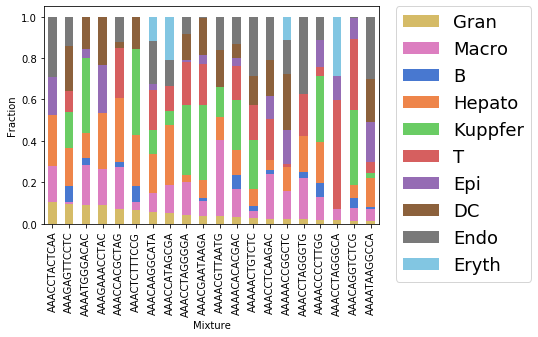

Sorted by Gran cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

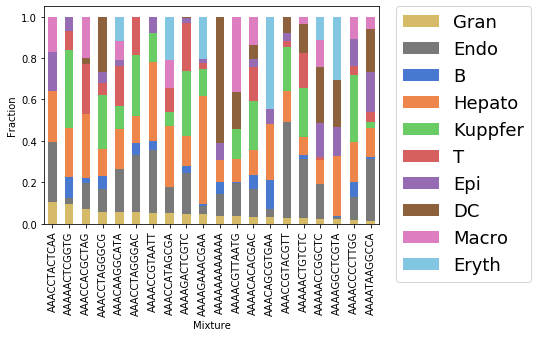

Sorted by Gran cell fractions (>=1.0%), then by Eryth cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

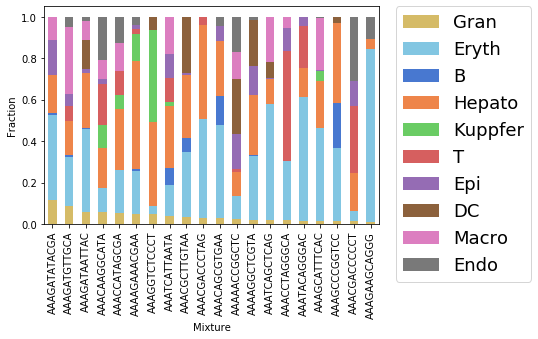

Sorted by Eryth cell fractions (>=1.0%), then by B cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

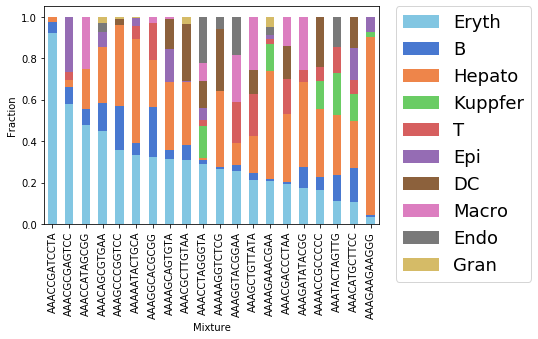

Sorted by Eryth cell fractions (>=1.0%), then by Hepato cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

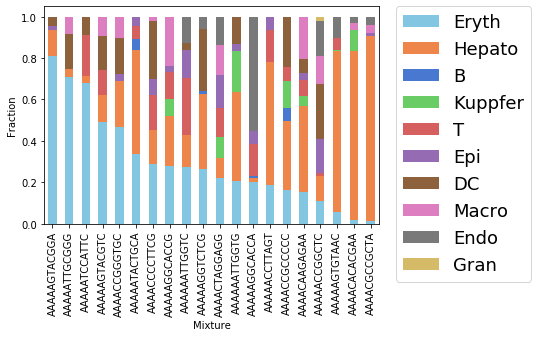

Sorted by Eryth cell fractions (>=1.0%), then by Kuppfer cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

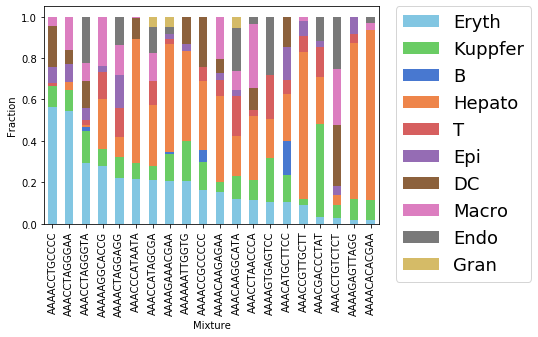

Sorted by Eryth cell fractions (>=1.0%), then by T cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

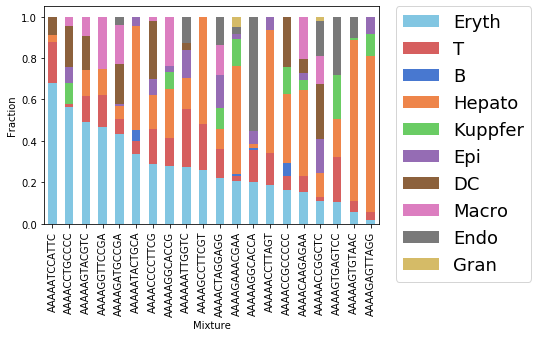

Sorted by Eryth cell fractions (>=1.0%), then by Epi cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

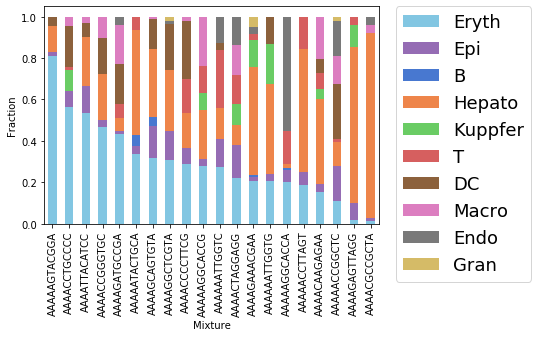

Sorted by Eryth cell fractions (>=1.0%), then by DC cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

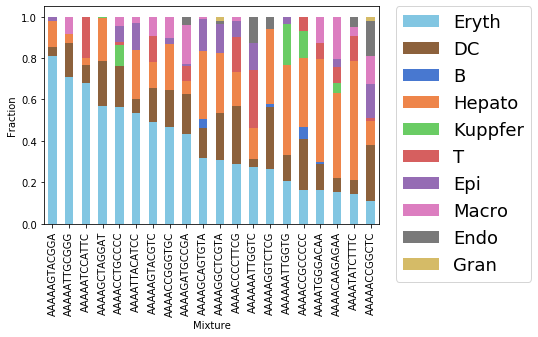

Sorted by Eryth cell fractions (>=1.0%), then by Macro cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

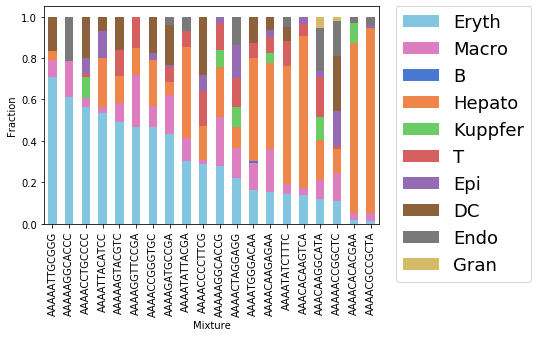

Sorted by Eryth cell fractions (>=1.0%), then by Endo cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

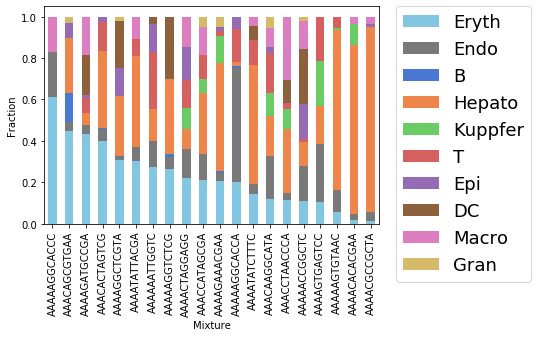

Sorted by Eryth cell fractions (>=1.0%), then by Gran cell fractions (>=1.0%)


<Figure size 432x288 with 0 Axes>

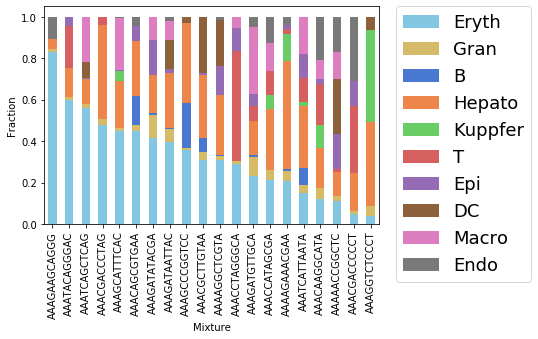

In [16]:
#【自動版】
#breakをコメントアウトして使う

l=[]
for first_item in celltypes:
    #全細胞種の組み合わせを走査する。
    for second_item in celltypes:
        if first_item == second_item:
            continue
        if not my_loop(df_fractions, first_item, second_item, cutoff1, cutoff2, diff, head=head, comments=False,strict=True, show_legends=show_legends):#if False
            print('insufficient number of bulks met criteria for '+first_item+' and '+second_item+'... try decreasing diff/head?')
        #break
    #break